# LMS 따라치기

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
%cd /content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기

/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기


In [31]:
ls

 sample_submission.csv   train.csv
 test.csv               '나의 첫 번째 캐글 경진대회, 무작정 따라해보기.ipynb'


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [33]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
data_dir = '/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/train.csv
/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/test.csv


In [35]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [36]:
# 라벨 따로 저장
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


# 결측치 확인

<Axes: >

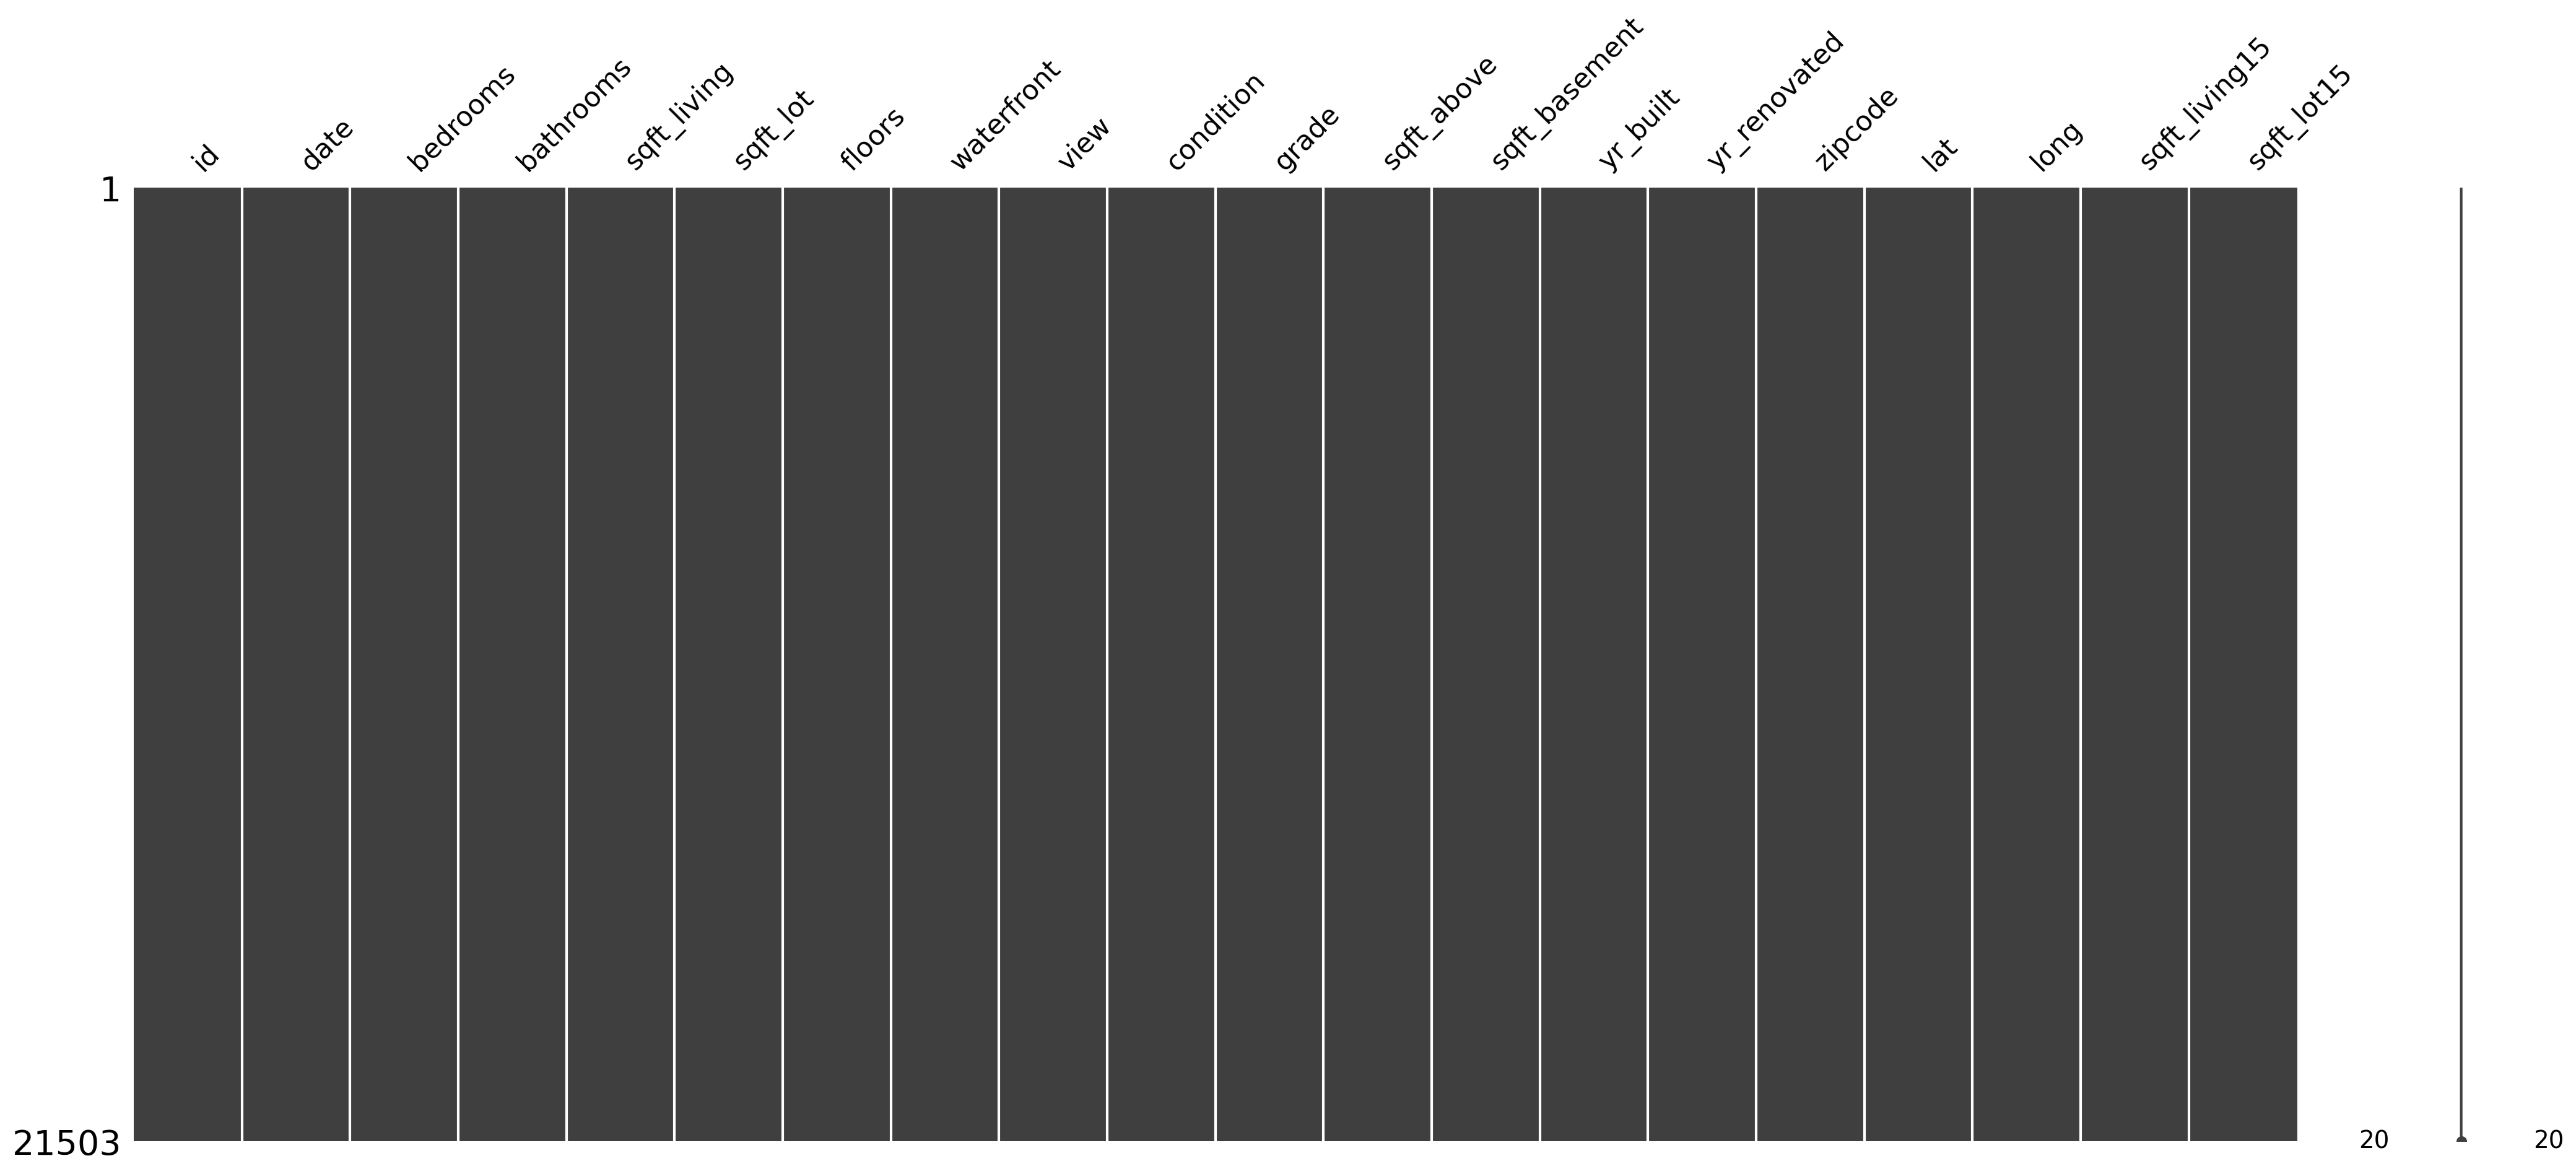

In [38]:
msno.matrix(data)

In [39]:
# 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


# 변수 정리

In [40]:
# 나중 예측결과 제출을 대비해 따로 빼둠
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [41]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 분포 확인

코드 리뷰 당시  sns.kdeplot(data[columns[count]], ax=ax[row][col])가 계속 에러가 생겨서 왜 그런지 찾다가
seaborn 0.11버전부터 data를 명시해야 된다는걸 발견

* 2019년 당시에는 0.9.0에서는 keyword argument로 안 받아도 작동 되었었음
* LMS 상 seaborn 버전은 0.11.2 여서, data=None가 Default로, data를 명시해서 input을 진행해 줘야 함
* https://seaborn.pydata.org/archi

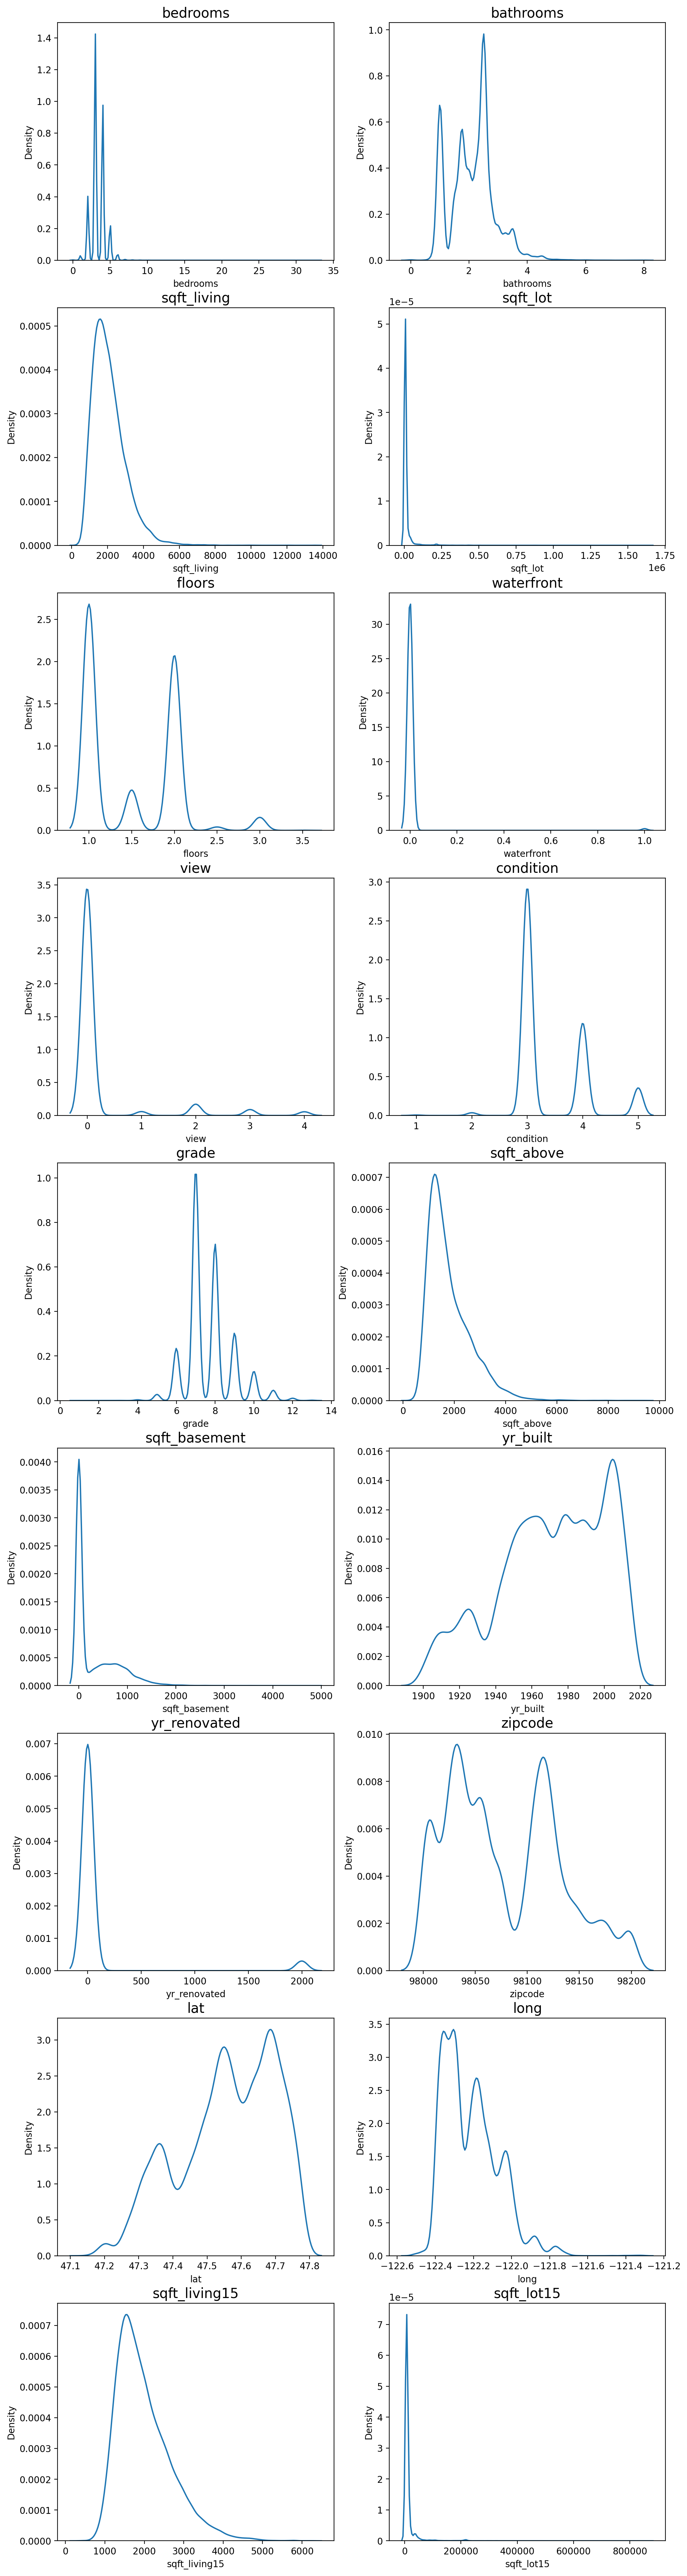

In [42]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

# 데이터 정규화

한쪽으로 치우쳐진 데이터들 같은 경우 로그 변환을 통해 정규분포에 가깝게 만들 수 있슴

In [43]:
# 비 정규적인 칼럼 선택해 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

# 로그 변환
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


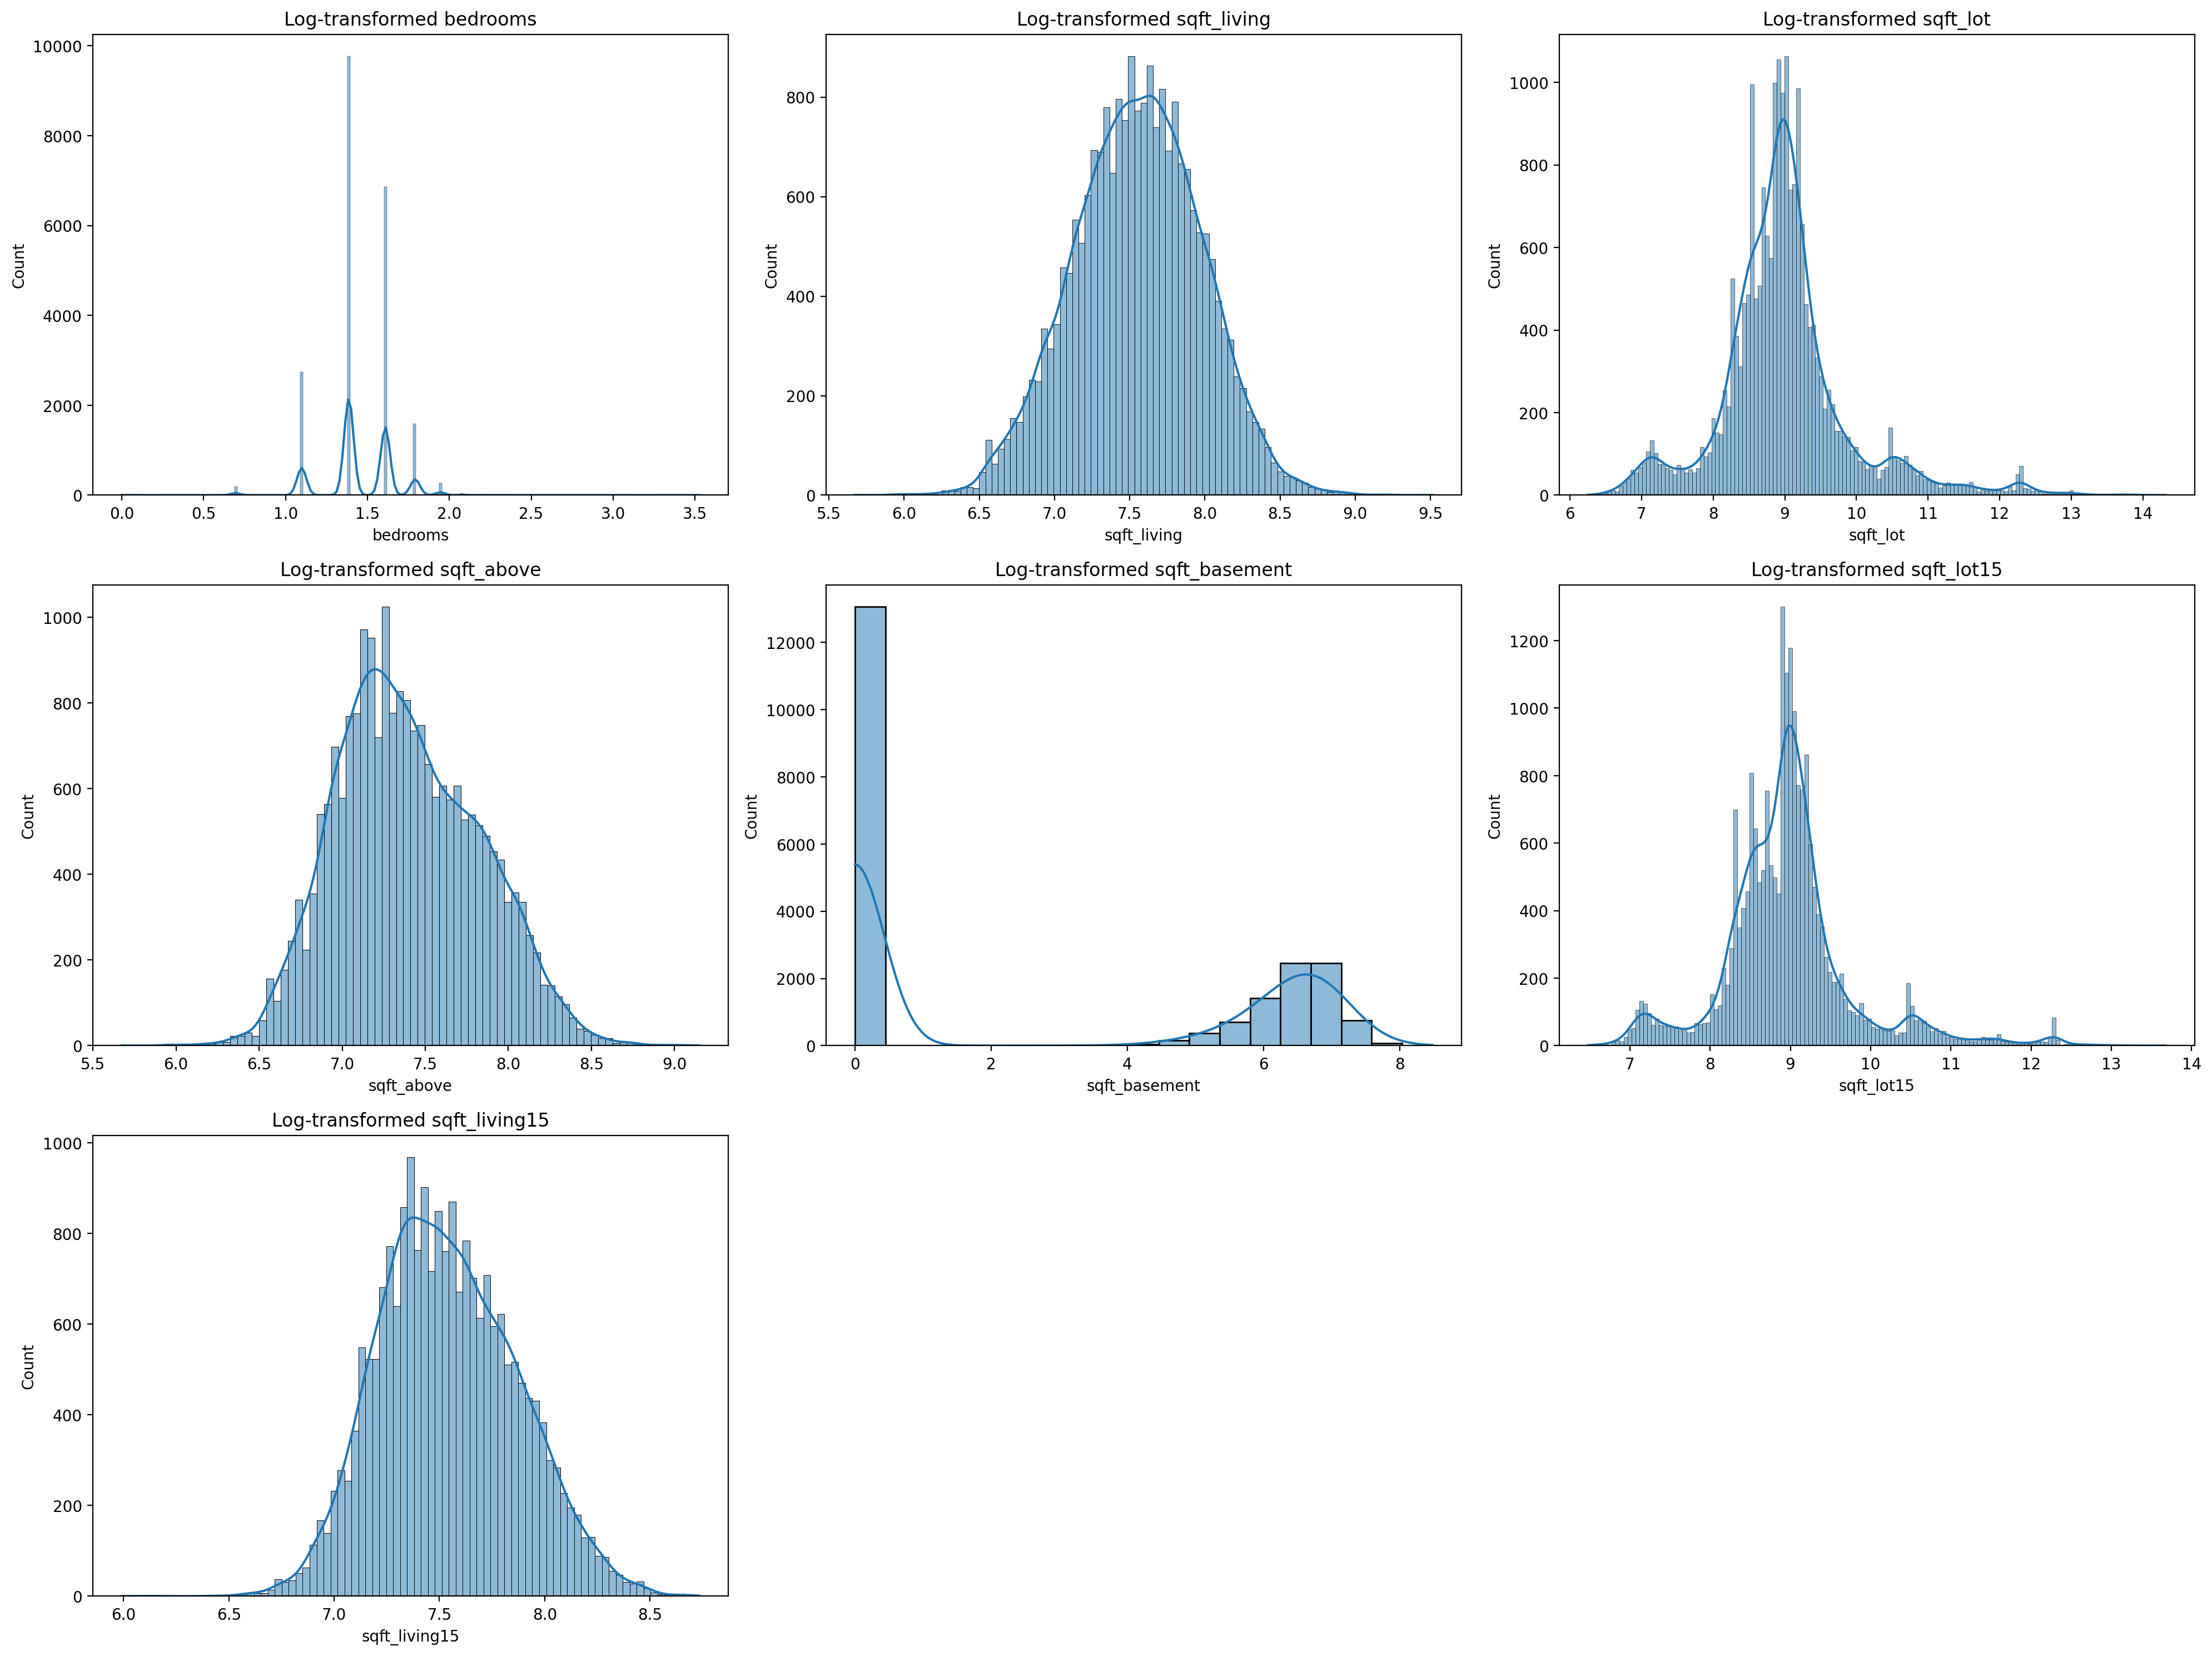

In [44]:
# 로그 변환된 컬럼들 시각화
plt.figure(figsize=(20, 15))

for i, column in enumerate(skew_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Log-transformed {column}')

plt.tight_layout()
plt.show()

# 가격도 로그 변환 시행

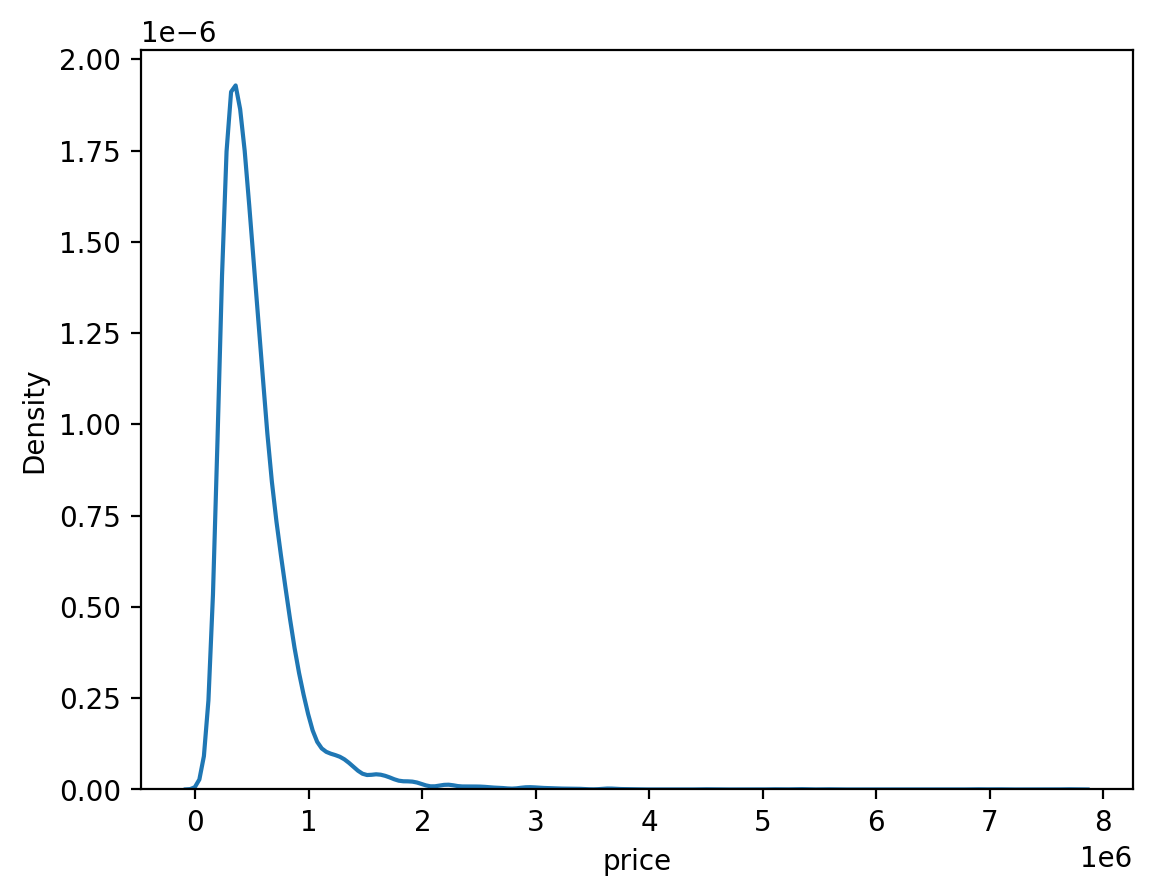

In [47]:
# 이전 가격 양상 확인
sns.kdeplot(y)
plt.show()

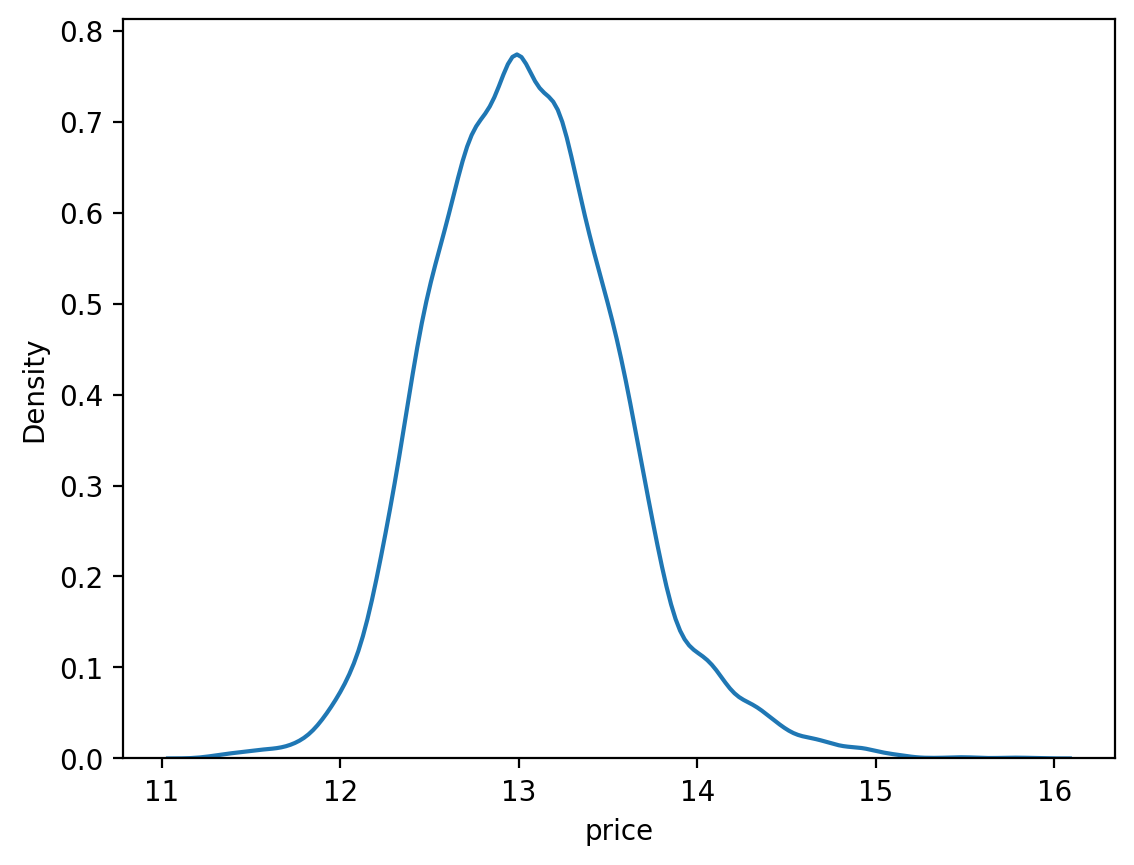

In [48]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [49]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 모델 학습

In [50]:
# 각각의 모델 저장
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


# ✓ Cross Validation

In [51]:
# 교차 검증을 통한 성능 평가 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [52]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
Y

# AveragingBlending()

In [53]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [54]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683])

# 케글 결과 제출

In [57]:
# 결과 양식 확인
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [58]:
# 샘플과 같은 형식으로 데이터 생성
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


In [60]:
# 제출 csv 생성
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

# 하이퍼 파라미터 튜닝하기 [이전 작업 재시행]

In [62]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [63]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [67]:
#train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train['date'] = train['date'].astype(str).apply(lambda i: i[:6]).astype(int)
#test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].astype(str).apply(lambda i: i[:6]).astype(int)

In [68]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [69]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [70]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [72]:
del test['id']

test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


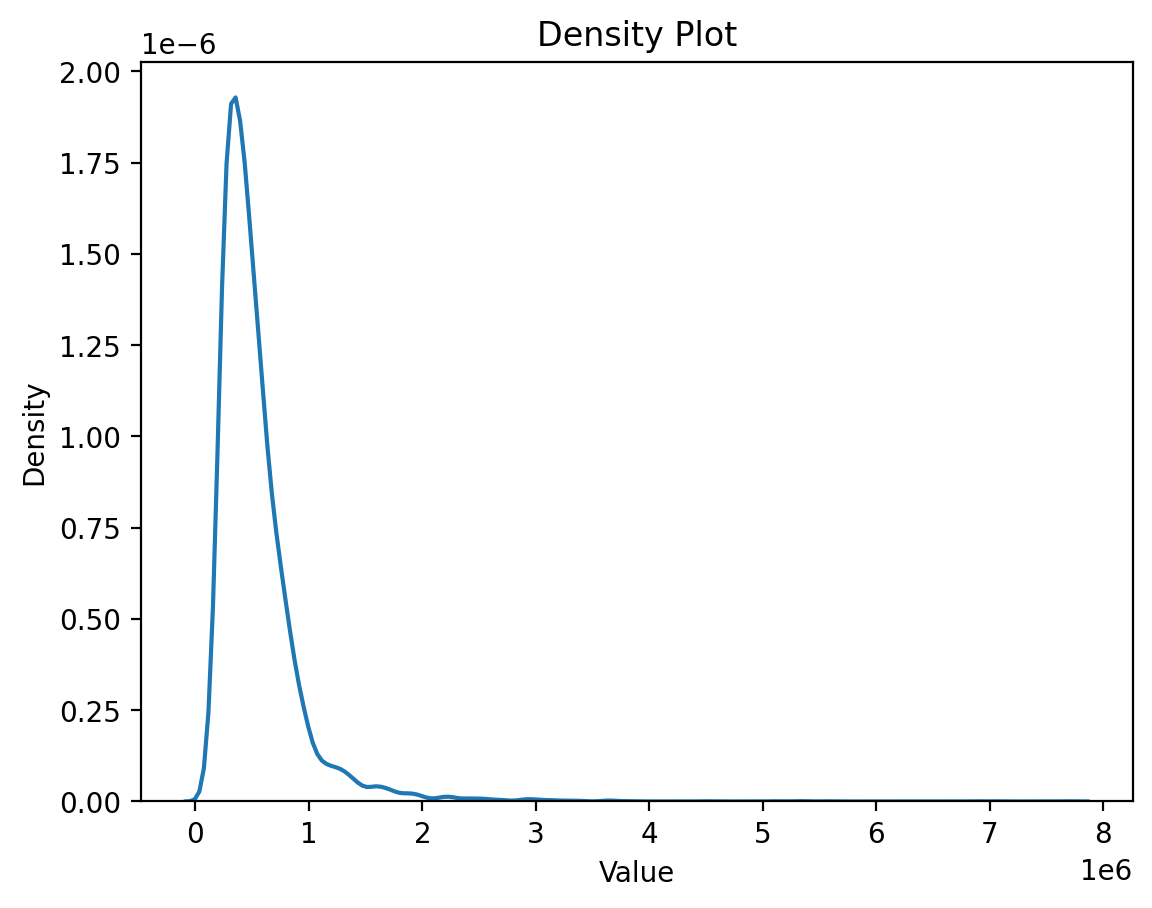

In [74]:
# y 분포 확인
sns.kdeplot(y)

plt.title("Density Plot")
plt.xlabel("Value")
plt.ylabel("Density")

plt.show()


In [75]:
# y분포 또한 왼쪽으로 치우쳐져 있다는 문제가 있어서 로그 변환을 시행해주고 다시 제출할때 원상복구 작업 시행
y = np.log1p(y)
# np.expm1()로 원상복귀
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

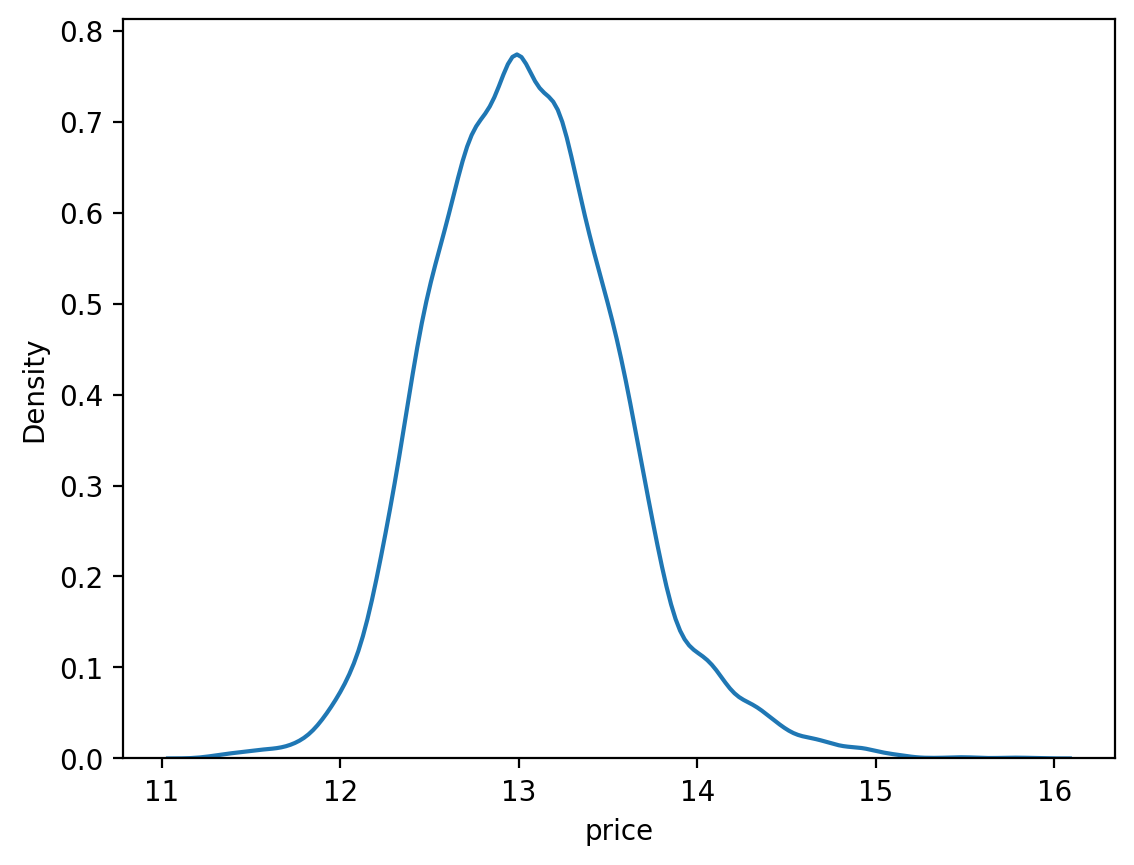

In [76]:
sns.kdeplot(y)
plt.show()

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [78]:
# train_test_split과 mse계산읠 위해 함수 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [79]:
# 기존 y_test나 y_pred데이터에 로그 변환을 진행했기에 np.expm1()을 통해 원상복귀 작업을 잊지 말아야 한다
def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [80]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [81]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [83]:
# 이런식으로 모델의 이름도 발견 가능
gboost.__class__.__name__

'GradientBoostingRegressor'

In [85]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    # [[YOUR CODE]]
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

    # 모델 학습
    model.fit(X_train, y_train)
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

# data frame에 저장
score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047364


{'GradientBoostingRegressor': 134486.27354015064,
 'XGBRegressor': 129606.84410193958,
 'LGBMRegressor': 123071.46972897886,
 'RandomForestRegressor': 141426.82683490147}

In [87]:
def get_scores(models, train, y):
    df = {}

    # 데이터프레임의 데이터 유형 확인
    print(train.dtypes)

    # 모든 열이 int, float, bool 또는 categorical인지 확인
    for column in train.columns:
        if not pd.api.types.is_numeric_dtype(train[column]):
            train[column] = pd.to_numeric(train[column], errors='coerce')

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 계산
        df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장 및 정렬
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    print(score_df)
    return score_df

get_scores(models, train, y)

date               int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779
                                    RMSE
GradientBoostingRegressor  128360.196497
RandomForestRegressor 

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
XGBRegressor,117618.223554
LGBMRegressor,111920.367359


# 그리드 탐색 기법

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [90]:
# 그리드 탐색에 사용할 모델 불러오기
model = LGBMRegressor(random_state=random_state)

In [91]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [92]:
# 그리드 서치 결과를 볼 수 있음. 하지만 원하는 정보가 보이지 않으니 아래 방식 진행
grid_model.cv_results_

{'mean_fit_time': array([0.38633642, 0.45050645, 0.90971928, 2.34811387]),
 'std_fit_time': array([0.02881212, 0.0640739 , 0.09869565, 0.09227288]),
 'mean_score_time': array([0.02406101, 0.03596783, 0.08439465, 0.1103281 ]),
 'std_score_time': array([0.00674668, 0.00500836, 0.02100066, 0.03957892]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [93]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [94]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [98]:
# 여기에 코드를 작성하세요.
results = pd.DataFrame(params)
results['score'] = score
results.head()

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [99]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [100]:
# 사실 이 모델은 로그를 취해진 데이터에 MSE를 구한거기에 사실상 RMSLE값이라 칼럼 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [101]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results_sorted = results.sort_values(by='RMSLE', ascending=True)

# 결과 출력 (인덱스 제외)
print(results_sorted.to_string(index=False))

 max_depth  n_estimators     score    RMSLE
        10           100 -0.027027 0.164399
        10            50 -0.029177 0.170814
         1           100 -0.055020 0.234564
         1            50 -0.073394 0.270914


In [102]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  # GridSearch 모델 초기화
  grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
  # 모델 학습
  grid_model.fit(train, y)

  # 결과 저장
  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  # 데이터 프레임 생성
  results = pd.DataFrame(params)
  results['score'] = score

  # RMSLE 값 계산 후 컬럼명 변경
  results['RMSLE'] = np.sqrt(-1 * results['score'])

  # RMSLE 값이 낮은 순으로 정렬
  results = results.rename(columns={'RMSE': 'RMSLE'})
  results = results.sort_values(by='RMSLE', ascending=True)

  return results

In [103]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [104]:
# 위 결과를 통해 max_depth 10, n_estimators 100이 가장 좋은 결과인것을 발견
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [105]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [106]:
# sample submission 가져와 제출 형식 파일 확인
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [107]:
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [108]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [109]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/submission_lgbm_RMSLE_0.164399.csv


In [111]:
def save_submission(model, train, y, test, model_name, rmsle):
  # 모델 학습
  model.fit(train, y)

  # 예측
  prediction = model.predict(test)

  # 예측값 변환
  prediction = np.expm1(prediction)

  # 제출 파일 경로
  submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)

  # 제출 파일 생성
  submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
  submission['price'] = prediction
  submission.to_csv(submission_csv_path, index=False)

  print(submission_csv_path)


In [112]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/submission_lgbm_RMSLE_0.164399.csv


In [113]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/content/drive/MyDrive/대학/활동/아이펠/lms/기초다지기_rs8/나의 첫 번째 캐글 경진대회, 무작정 따라해보기/submission_lgbm_RMSLE_0.164399.csv


# 11. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기 [프로젝트]